In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff7 as ds
from copy import copy as dup
from scipy.integrate import odeint

#for 3d plots
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

import numba as nb

In [2]:
%matplotlib widget

(500, 500)
[-10.          -9.95991984  -9.91983968  -9.87975952  -9.83967936
  -9.7995992   -9.75951904  -9.71943888  -9.67935872  -9.63927856]
[-20. -20. -20. -20. -20. -20. -20. -20. -20. -20.]
[-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
[-20.         -19.91983968 -19.83967936 -19.75951904 -19.67935872
 -19.5991984  -19.51903808 -19.43887776 -19.35871743 -19.27855711]


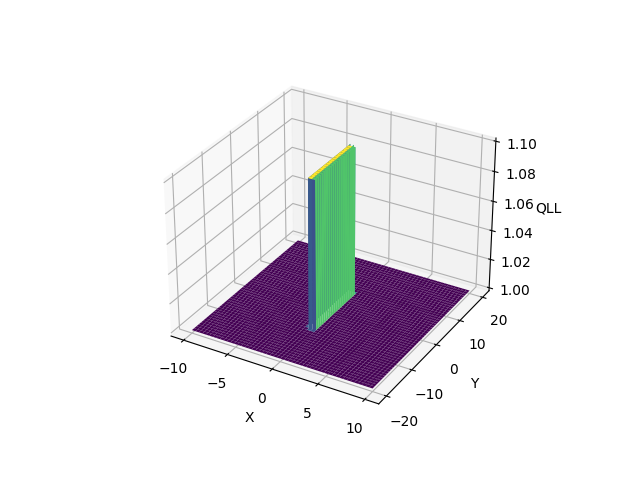

In [3]:
nx = 500
ny = 500

xmax=10
ymax=20
deltaX= 2*xmax/nx


xmid = int(nx/2)
ymid = int(ny/2)

mesh = np.meshgrid(np.linspace(-xmax,xmax,nx),np.linspace(-ymax,ymax,ny))
X = mesh[0].T
Y = mesh[1].T
print(np.shape(X))
print(X[0:10,0])
print(Y[0:10,0])

print(X[0,0:10])
print(Y[0,0:10])

#Fliq = np.ones(np.shape(X)) - 0.001*(X**2 + Y**2) 
Fliq = np.ones(np.shape(X)) 
Fliq[xmid-10:xmid+10,ymid-100:ymid+100] = 1.1

""" plt.figure()

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,X,cmap='viridis')
#ax.plot_surface(X,Y,Fliq,cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('X')
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Y,cmap='viridis')
#ax.plot_surface(X,Y,Fliq,cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Y')
plt.show() """

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Fliq,cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('QLL')
plt.show()

In [23]:
#calculate diffusion differential equation DIY
# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

counter = 10000

dt = 1000.0 # microseconds
tmax = counter*dt

Fliq_next = np.copy(Fliq)


for i in range(counter):
    Fliq_next = Fliq_next + ds.diffuse_2d(Fliq_next,0,D)*dt 

In [25]:
#try solving with odeint instead #NOTE: not wokring right 
# This is the 0-d run
# Bundle parameters for ODE solver
params = D #np.array([D])

ylast = dup(Fliq)

# Time steps
t0 = 0.0
tinterval = [t0, tmax]

# Call the ODE solver
layer = 0

# Integrate up to next time step
y = odeint(ds.diffuse_2d, np.reshape(ylast,np.prod(np.shape(ylast))), tinterval, args=(params,))
ylast = list(y[1,:])

ValueError: Initial condition y0 must be one-dimensional.

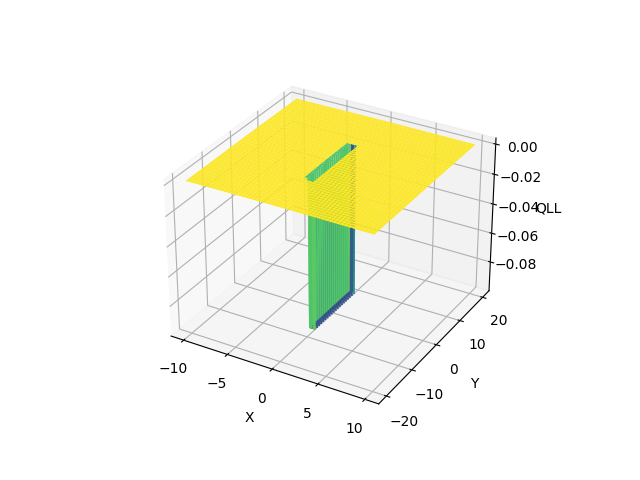

In [19]:
#plot the original minus the calculated diffusive effects
plt.figure()
ax = plt.axes(projection='3d')


#ax.plot_surface(X,Y,Fliq_next,cmap='viridis')
ax.plot_surface(X,Y,Fliq_next-Fliq,cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('QLL')
plt.show()

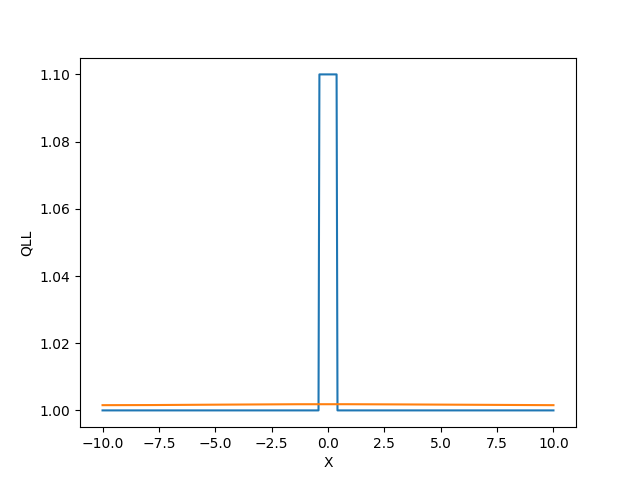

20.080160320641284
20.034064313178884


In [20]:
#slice through the middle of the liquid before diffusion in X

# print(X[:,int(ny/2)])

plt.figure()
ax = plt.axes()
ax.plot(X[:,int(ny/2)],Fliq[:,int(ny/2)])
ax.plot(X[:,int(ny/2)],Fliq_next[:,int(ny/2)])
ax.set_xlabel('X')
ax.set_ylabel('QLL')
plt.show()

print(np.trapz(Fliq[:,int(ny/2)],X[:,int(ny/2)],))
print(np.trapz(Fliq_next[:,int(ny/2)],X[:,int(ny/2)],))


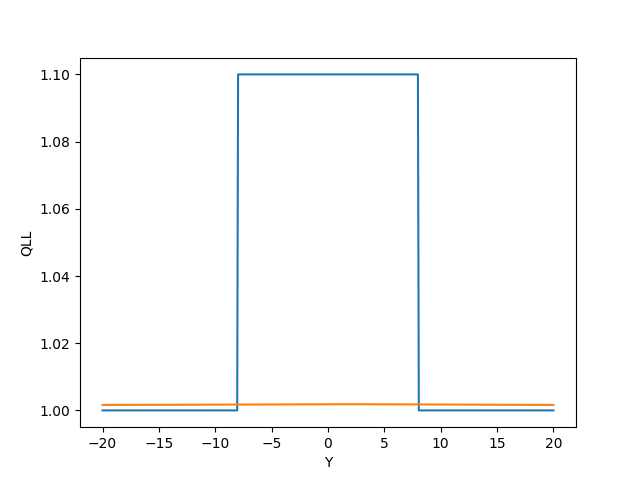

41.60320641282565
40.06943481952784


In [21]:
#slice through the middle of the liquid before diffusion in Y


plt.figure()
ax = plt.axes()
ax.plot(Y[xmid,:],Fliq[xmid,:])
ax.plot(Y[xmid,:],Fliq_next[xmid,:])
ax.set_xlabel('Y')
ax.set_ylabel('QLL')
plt.show()


print(np.trapz(Fliq[xmid,:],Y[xmid,:]))
print(np.trapz(Fliq_next[xmid,:],Y[xmid,:]))


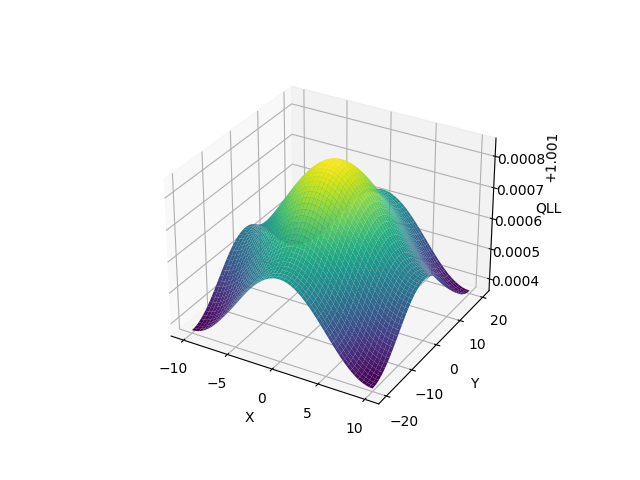

In [22]:
#plot the results
plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(X,Y,Fliq_next,cmap='viridis')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('QLL')
plt.show()